In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from joblib import dump
from sklearn import set_config
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             f1_score, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_tree

from ml_model import PipelineManager, PredictionPipeline
from utils.GPU_models import KerasClassifierModel, gpu_model_hub
from utils.preprocessing_utils import (clean_and_preprocess_datasets,
                                       clean_labs, clean_notas,
                                       clean_sociodemograficos,
                                       disease_tests_list, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


2022-07-01 00:33:36.287776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 00:33:36.287813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/juanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/juanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
retrain_with_class_weight=False
add_gpu_prediction = False
consolidate_classes = False
cv = 5
n_iter = 20
n_jobs = -3

# False, 'oversample', or 'undersample'
balance_classes = 'oversample'
cleaning_dict_path = "utils/lab_test_name_aggregation.json"
save_path = Path('data') / 'output' / 'best_model.pickle'

## Data load

In [3]:
with open(cleaning_dict_path, "r") as in_file:
    dict_tests = json.load(in_file)

df_notas = pd.read_csv('data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('data/sociodemografico.csv', sep=';')

In [4]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [5]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [7]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


## Data Cleaning

In [8]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios, name_aggregation_dict=dict_tests)
df_notas = clean_notas(df_notas, apply_lemmatization=False)

### Merge the sociodemographic data with the medical notes dataset

In [9]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"se explica acerca del programa, Se recomienda ..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente al diagnostico. Ref...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL POR CADA FOSA ...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO EN UN MES-INFECTOLOGIA VALORACI...


## Feature Engineering

In [11]:
# Consolidate the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,top_lab_code,top_lab_avg_value,top_lab_max_value,top_lab_count,total_lab_count,first_lab_date,last_lab_date,date_diff_first_last,date_diff_mean,date_diff_max,liver_damage_count,liver_damage_max,hematic_info_count,hematic_info_max,bacterias_count,bacterias_max,hormones_count,hormones_max,other_diseases_count,other_diseases_max,kidney_damage_count,kidney_damage_max,heart_damage_count,heart_damage_max,minerals_count,minerals_max,white_cells_count,white_cells_max,vih_count,vih_max,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,902213,10.0,10.0,1.0,8.0,1.609114e+18,1.609114e+18,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,1.0,189.0,0.0,0.0,2.0,500.0,3.0,150.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Label encoding

In [12]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  977,    94,  2614,  1970, 60586, 47408,  6278, 17437,  2808]))

## Train-test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  195,    19,   523,   394, 12117,  9481,  1256,  3487,   562]))

## Class Balancing

In [14]:
if balance_classes == 'oversample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
elif balance_classes == 'undersample':
    # Using a naive oversampling approach
    sampler = RandomUnderSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([19, 19, 19, 19, 19, 19, 19, 19, 19]))

## Further (optional) feature engineering

In [15]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "universal"

if add_gpu_prediction:
    model_function = gpu_model_hub
    clf = KerasClassifierModel(
        build_fn=model_function,
        class_number=len(df_notas[target_feature].unique()),
        embedding = embedding,
        epochs=400,
        batch_size=400,
        verbose=10,
    )

    clf.fit(X_train[text_feature], y_train)
    clf.plot_learning_curves('data/output/gpu_model')

In [16]:
if add_gpu_prediction:
    y_pred = clf.predict(X_test[text_feature])
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())

In [17]:
if add_gpu_prediction:
    X_pred = clf.predict(df_merge[text_feature])
    df_merge['GPU_prediction'] = X_pred
    df_merge

## Hyperparameter Setup

In [18]:
# Select the numerical features that will be used in the model
numerical_features = list(
    set(
        [
            "Edad",
            "top_lab_avg_value",
            "top_lab_max_value",
            "top_lab_count",
            "total_lab_count",
            "date_diff_mean",
            "date_diff_max",
            "first_lab_date",	
            "last_lab_date",
            "date_diff_first_last",
        ]
        + list(df_merge.drop(columns="IDRecord").select_dtypes(include="int64").columns)
        + [f'{test[1]}_count' for test in disease_tests_list()]
        + [f'{test[1]}_max' for test in disease_tests_list()]
    )
)

# Now select the categorical features
categorical_features = [
    "Genero",
    "GrupoEtnico",
    # "AreaResidencial",
    "EstadoCivil",
    # "TSangre",
    # "Tipo",
    "top_lab_code",
]

In [19]:
# Add the GPU prediction if we are using a GPU model for predicting the data
if 'GPU_prediction' in df_merge:
    categorical_features.append('GPU_prediction')

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(1, 200, 10, dtype=int),
    "max_depth": list(np.linspace(2, 15, 5, dtype=int)),
    "eta": np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 5, dtype=float),
    "reg_alpha": np.linspace(0, 10, 5, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    "C": np.linspace(0, 5, 20, dtype=float),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "class_weight": ["balanced", None],
    "coef0": np.linspace(0, 5, 20, dtype=float),
    "degree": np.linspace(1, 5, 10, dtype=int),
}
estimator = SVC()
pipeline.add_estimator(estimator, param_grid)


pipeline.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'EstadoCivil',
                                                   'top_lab_code']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScal...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'mas',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                             

## Hyperparameter tuning

In [49]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=df_merge[target_feature])

scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }
best_model = pipeline.find_best_model(
    X_train,
    y_train,
    cv=cv,
    n_iter=n_iter,
    n_jobs=n_jobs,
    scoring=scoring,
    random_state=7,
    refit='Weighted_F1',
    verbose = 5,
    # error_score='raise',
    )

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5, eval_metric=None, gamma=1.0,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=0.5, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=2.5, ...), estimator__colsample_bytree=1.0, estimator__eta=0.5, estimator__gamma=0.5, estimator__max_depth=8, estimator__min_child_weight=15.125, estimator__n_estimators=1, estimator__reg_alpha=10

/home/juanma/miniconda3/envs/DS4A_Project/lib/python3.9/site-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


KeyboardInterrupt: 

In [21]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'EstadoCivil',
                                                   'top_lab_code']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['sable', '...
                               eval_metric=None, gamma=1.0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.5,
                               max_bin=256, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=11, max_leaves=0,
                               min_child_weight=0.5, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [22]:
with pd.option_context('display.max_columns', None):
    display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_preprocessor__categorical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,param_estimator__kernel,param_estimator__degree,param_estimator__coef0,param_estimator__class_weight,param_estimator__C,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,split2_test_Weighted_F1,split3_test_Weighted_F1,split4_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
14,0.712399,0.070282,0.014510,0.001240,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.325,0.0,2.5,200,0.5,11,1.0,0.5,1.0,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,NaN,NaN,{'preprocessor__text__vectorizer': CountVector...,0.435185,0.416667,0.407407,0.453704,0.351852,0.412963,0.034446,1,0.397485,0.382446,0.423343,0.428852,0.351541,0.396733,0.028237,1
150,0.363069,0.020013,0.019029,0.004799,"CountVectorizer(ngram_range=(3, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),1.0,10.0,2.5,133,5.375,11,0.0,0.336667,0.4,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,NaN,NaN,{'preprocessor__text__vectorizer': CountVector...,0.305556,0.435185,0.444444,0.398148,0.407407,0.398148,0.049344,3,0.283691,0.406570,0.440336,0.407096,0.420932,0.391725,0.055397,2
51,0.483474,0.039581,0.012410,0.000796,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(strategy='median'),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.775,10.0,0.0,67,0.5,11,0.25,0.173333,0.4,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,NaN,NaN,{'preprocessor__text__vectorizer': CountVector...,0.416667,0.407407,0.398148,0.398148,0.361111,0.396296,0.018885,4,0.395795,0.429692,0.408403,0.374790,0.340413,0.389818,0.030456,3
54,0.089999,0.009538,0.011266,0.000580,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(sublinear_tf=True),RobustScaler(),SimpleImputer(strategy='median'),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),1.0,0.0,2.5,23,5.375,15,0.0,0.445556,0.2,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,NaN,NaN,{'preprocessor__text__vectorizer': CountVector...,0.425926,0.453704,0.342593,0.407407,0.388889,0.403704,0.037314,2,0.434195,0.427311,0.365741,0.332120,0.356259,0.383125,0.040462,4
152,0.260293,0.095058,0.014689,0.001182,"CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=ElasticNet()),0.775,7.5,0.0,111,5.375,11,0.75,0.445556,1.0,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,NaN,NaN,{'preprocessor__text__vectorizer': CountVector...,0.361111,0.462963,0.314815,0.398148,0.351852,0.377778,0.050171,7,0.355391,0.407563,0.329879,0.365143,0.318394,0.355274,0.031102,5
271,0.429693,0.334127,0.014268,0.001625,"CountVectorizer(ngram_range=(3, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",StandardScaler(),SimpleImputer(strategy='most_frequent'),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.775,0.0,0.0,45,0.5,5,0.25,0.5,0.8,"XGBClassifier(base_score=N

In [23]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
14,1,1,0.712399,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.412963,0.396733
150,2,3,0.363069,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.398148,0.391725
51,3,4,0.483474,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.396296,0.389818
54,4,2,0.089999,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(sublinear_tf=True),RobustScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.403704,0.383125
152,5,7,0.260293,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(),SelectFromModel(estimator=ElasticNet()),0.377778,0.355274
...,...,...,...,...,...,...,...,...,...,...,...
257,296,285,0.100046,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=Lasso()),NaN,NaN
45,297,300,0.095645,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 3),\n ...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Lasso()),NaN,NaN
41,298,299,0.119397,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Lasso()),NaN,NaN
270,299,293,0.044455,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(),SelectFromModel(estimator=Lasso()),NaN,NaN


In [24]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
14,1,1,0.712399,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.412963,0.396733
150,2,3,0.363069,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.398148,0.391725
51,3,4,0.483474,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.396296,0.389818
54,4,2,0.089999,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(sublinear_tf=True),RobustScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.403704,0.383125
152,5,7,0.260293,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(),SelectFromModel(estimator=ElasticNet()),0.377778,0.355274
...,...,...,...,...,...,...,...,...,...,...,...
257,296,285,0.100046,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=Lasso()),NaN,NaN
45,297,300,0.095645,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 3),\n ...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Lasso()),NaN,NaN
41,298,299,0.119397,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Lasso()),NaN,NaN
270,299,293,0.044455,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(),SelectFromModel(estimator=Lasso()),NaN,NaN


In [25]:
# Retrain the model using a sample-weighting mechanism to try to compensate for the dataset imbalance
if retrain_with_class_weight:
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train,
    )

    best_model.fit(X_train, y_train, estimator__sample_weight=sample_weights)

## Scoring

In [26]:
score = pipeline.score(X_test, y_test)
score

,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,0.762089,0.229672,0.368704,0.229672,0.164181,0.26951,"[[333, 49, 48, 98, 121, 60, 39, 19, 15], [0, 7...","[[0.0029695553692771406, 0.0004369616008846243...",precision recall f1-score ...


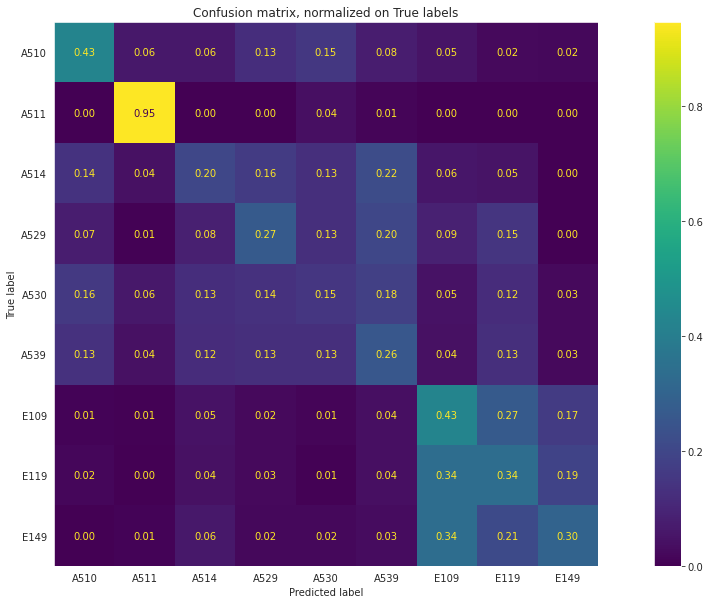

In [48]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(X_test),
                                display_labels=labels_decoded, normalize='true', ax=ax, cmap='viridis', values_format=".2f")
    _ = ax.set_title('Confusion matrix, normalized on True labels')
    plt.show()

In [28]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A510,0.02,0.43,0.05,782.00
A511,0.01,0.95,0.03,75.00
A514,0.03,0.20,0.06,2091.00
A529,0.03,0.27,0.06,1576.00
A530,0.56,0.15,0.24,48469.00
A539,0.49,0.26,0.34,37927.00
E109,0.18,0.43,0.26,5022.00
E119,0.27,0.34,0.30,13950.00
E149,0.11,0.30,0.16,2246.00
accuracy,0.23,0.23,0.23,0.23


# Model Characterization

## Model Features

In [29]:
# Building the fmap file needed to correctly give names to the features in the decision tree plot
fmap = pd.DataFrame(best_model.named_steps['feature_selector'].get_feature_names_out(best_model.named_steps['preprocessor'].get_feature_names_out()), columns=['feature'])
# Feature type q is quantitative, feature type i is binary
fmap['feature_type'] = 'i'
fmap.loc[fmap.feature.str.contains('numerical__'), 'feature_type'] = 'q'
fmap['feature'] = fmap.feature.str.replace(' ', '_')
fmap['feature'] = fmap.feature.str.replace('numerical__', '')
fmap['feature'] = fmap.feature.str.replace('categorical__', '')
fmap_save_path = save_path.parent / 'feature_map.txt'
fmap.to_csv(str(fmap_save_path), sep="\t", header=False)
fmap

,feature,feature_type
0,Genero_Hombre,i
1,Genero_Mujer,i
2,GrupoEtnico_Mestizo,i
3,"GrupoEtnico_Negro,_Mulato,_Afrocolombiano_o_Af...",i
4,GrupoEtnico_Ninguno_de_los_anteriores,i
...,...,...
2502,text__x1_600_mg,i
2503,text__x1_genvoya_mipres,i
2504,text__x1_paraclinicos_dia,i
2505,text__xmes_educa_vida,i


In [30]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=800)
plot_tree(best_model.named_steps['estimator'], num_trees=2, ax=ax, fmap=str(fmap_save_path))
plt.show()

In [31]:
# Model test
print(f'Predicted :{label_encoder.inverse_transform(best_model.predict(X_test.iloc[905].to_frame().T))}, real: {label_encoder.inverse_transform([y_test[905]])}')

Predicted :['E109'], real: ['A539']


## Saving the best performing model and pipeline

### Saving the best model

In [32]:
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))

PermissionError: [Errno 13] Permission denied: 'data/output/best_model.pickle'

### Create and save the full prediction pipeline

In [ ]:
prediction_pipeline = PredictionPipeline(estimator=best_model, preprocessing_fn=clean_and_preprocess_datasets, label_encoder=label_encoder)
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(
    prediction_pipeline,
    str(save_path.parent / f"prediction_pipeline{save_path.suffix}"),
)

### Test the pipeline

### Preprocessed data

In [ ]:
prediction_pipeline.predict(X_test, preprocess_data=False)

### Raw data

In [ ]:
prediction_pipeline.predict(
    X={
        "df_sociodemograficos": pd.read_csv("data/sociodemografico.csv", sep=";"),
        "df_laboratorios": pd.read_csv("data/laboratorios.csv", sep=";"),
        "df_notas": pd.read_csv("data/notas.csv", sep=";"),
    }
)

In [ ]:
clean_data = clean_and_preprocess_datasets({
        "df_sociodemograficos": pd.read_csv("data/sociodemografico.csv", sep=";"),
        "df_laboratorios": pd.read_csv("data/laboratorios.csv", sep=";"),
        "df_notas": pd.read_csv("data/notas.csv", sep=";"),
    })

In [ ]:
from utils.preprocessing_utils import preprocess_json

import json
with open('utils/sample_example.json') as in_file:
    sample_data = json.load(in_file)
sample_data

preprocess_json(sample_data)

In [ ]:
prediction_pipeline.predict(
    X=preprocess_json(sample_data))